<a href="https://colab.research.google.com/github/nisaodabas/CNG483-Project2/blob/master/CNG483_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNG 483 – INTRODUCTION TO COMPUTER VISION**

## **Project 2 - Age Prediction based on Iris Biometric Data**
\\

### Nisa Nur Odabaş

---


In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform, RandomUniform
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model  
from keras.utils import np_utils
import matplotlib.pyplot as plt
from google.colab import output
from google.colab import drive

drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Create  dataset from .txt file**

In [0]:
def createDataSet(path):
    df = pd.read_csv(path, sep='\n')
    data = np.array(df)

    #print(data)
    numAttr = 0
    rows = []
    for row in data:        
        found = row[0].find("@ATTRIBUTE")
        if(found != -1):
            numAttr += 1
        else:
            # ignore @ATTRIBUTE rows
            rows.append(row[0].split(","))

    # delete @DATA row
    rows = np.array(rows[1:])

    labels = rows[:, -1].astype('int')
    
    labels = np.array([x - 1 for x in labels])

    if(numAttr == 6):
        features = rows[:, :numAttr-1].astype('float')
    else:
        features = rows[:, :numAttr-1].astype('int')
        # define feature selection
        #fs = SelectKBest(score_func=f_classif, k=4000)
        # apply feature selection
        #features = fs.fit_transform(features, labels)
        

    return features, labels

### **Plot history graph of the model**

In [0]:
def plotHistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### **Texture Features - 0 Hidden Layer**

In [0]:
def model_textr_0(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    ## 0 - Hidden Layer NN ##

    model = Sequential()
    model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dropout(0.8))
        
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 48

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
        

### **Texture Features - 1 Hidden Layer**

In [0]:
def model_textr_1(X, y, X_test, y_test, dim):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    ## 1 - Hidden Layer NN ##
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dropout(0.8))

    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.8))
        
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 48

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
    

### **Texture Features - 2 Hidden Layer**

In [0]:
def model_textr_2(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    ## 2 - Hidden Layer NN ##
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.6))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    model.add(Dropout(0.6))
    
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    numEpochs = 5000
    batches = 48

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
    

### **Texture Features - 3 Hidden Layer**

In [0]:
def model_textr_3(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)
    
    ## 3 - Hidden Layer NN ##
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    model.add(Dropout(0.5))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
    

### **Geometric Features - 0 Hidden Layer**

In [0]:
def model_geo_0(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 0 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(4, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    
    numEpochs = 5000
    batches = 28 

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
   
    

### **Geometric Features - 1 Hidden Layer**

In [0]:
def model_geo_1(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 1 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(8, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    #model.add(Dropout(0.2))

    model.add(Dense(5, activation='relu', kernel_initializer=RandomUniform(seed=1)))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64   

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Geometric Features - 2 Hidden Layer**

In [0]:
def model_geo_2(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 2 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(8, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(8, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Geometric Features - 3 Hidden Layer**

In [0]:
def model_geo_3(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 3 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(24, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(24, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Texture & Geometric Features - 0 Hidden Layer**

In [0]:
def model_combined_0(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 0 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))
    model.add(Dropout(0.1))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    numEpochs = 5000
    batches = 36

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)

### **Texture & Geometric Features - 1 Hidden Layer**

In [0]:
def model_combined_1(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 1 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))
    #model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu', kernel_initializer=RandomUniform(seed=1)))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    
    numEpochs = 5000
    batches = 26

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Texture & Geometric Features - 2 Hidden Layer**

In [0]:
def model_combined_2(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 2 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))
    #model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    numEpochs = 5000
    batches = 26

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Texture & Geometric Features - 3 Hidden Layer**

In [0]:
def model_combined_3(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)
    
    # 3 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(96, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(128, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(96, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.000001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 128

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Main**

In [0]:
if __name__ == "__main__":
    geometic_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TestingSet.txt"
    geometic_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TrainingSet.txt"

    texture_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TestingSet.txt"
    texture_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TrainingSet.txt"


    geo_x_train, geo_y_train = createDataSet(geometic_train_path)
    geo_x_test, geo_y_test = createDataSet(geometic_test_path)

    txtr_x_train, txtr_y_train = createDataSet(texture_train_path)
    txtr_x_test, txtr_y_test = createDataSet(texture_test_path)

    all_x_train = np.concatenate((txtr_x_train, geo_x_train), axis=1)
    all_x_test = np.concatenate((txtr_x_test, geo_x_test), axis=1)


### **Result: Texture - 0 Hidden Layer**

Epoch 00013: early stopping
Train: 55.967, Validation: 46.512, Test: 54.825


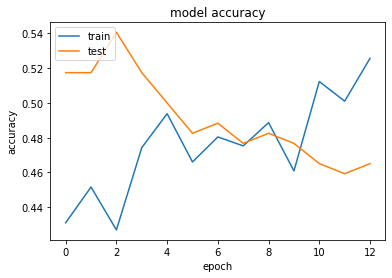

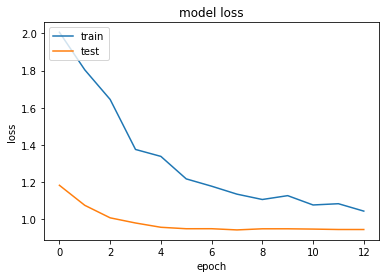

In [17]:
    model_textr_0(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Texture - 1 Hidden Layer**

Epoch 00011: early stopping
Train: 54.321, Validation: 50.000, Test: 53.289


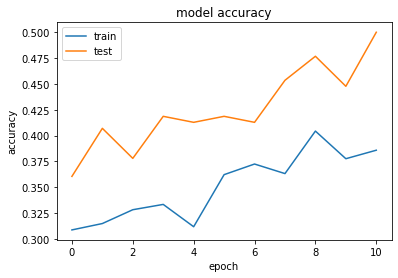

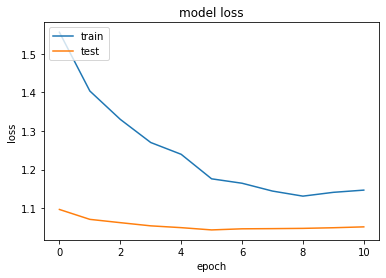

In [18]:
    model_textr_1(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Texture - 2 Hidden Layer**

Epoch 00063: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


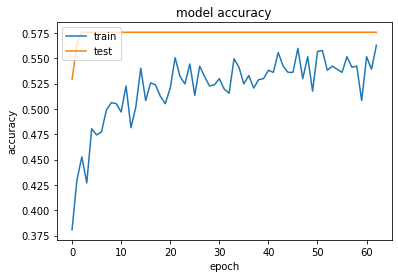

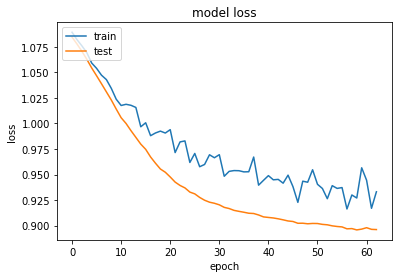

In [19]:
    model_textr_2(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Texture - 3 Hidden Layer**

Epoch 00132: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


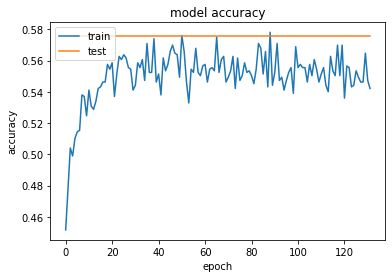

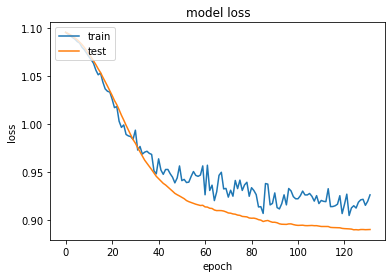

In [20]:
    model_textr_3(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Geometric - 0 Hidden Layer**

Epoch 00125: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


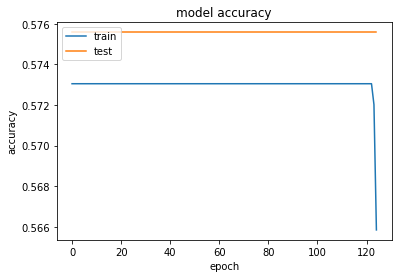

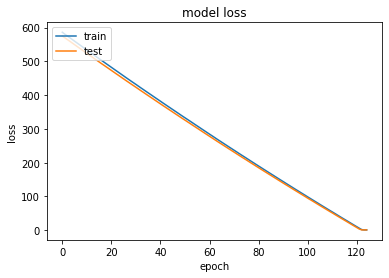

In [21]:
    model_geo_0(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Geometric - 1 Hidden Layer**

Epoch 00062: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


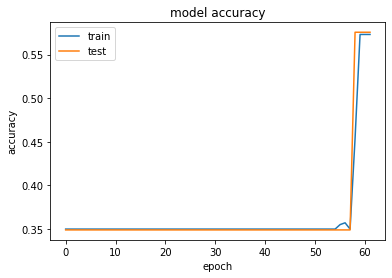

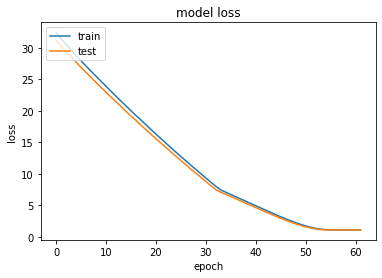

In [22]:
    model_geo_1(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Geometric - 2 Hidden Layer**

Epoch 00058: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


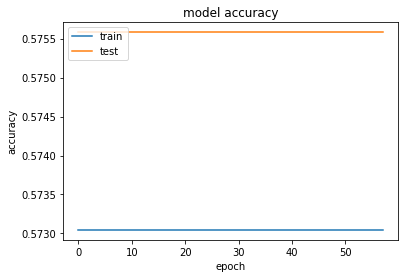

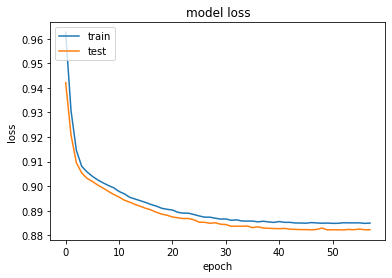

In [23]:
    model_geo_2(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Geometric - 3 Hidden Layer**

Epoch 00013: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


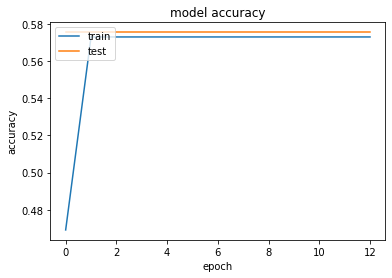

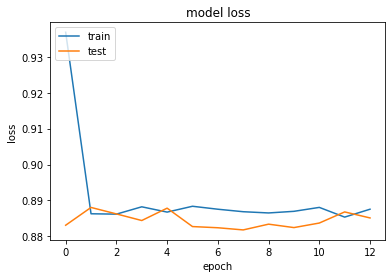

In [24]:
    model_geo_3(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Texture & Geometric - 0 Hidden Layer**

Epoch 00062: early stopping
Train: 51.337, Validation: 44.767, Test: 48.026


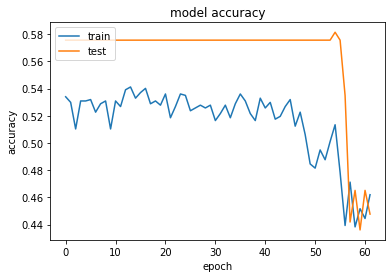

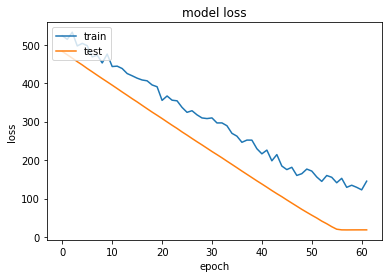

In [25]:
    model_combined_0(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

### **Result: Texture & Geometric - 1 Hidden Layer**

Train: 57.305, Validation: 57.558, Test: 57.895


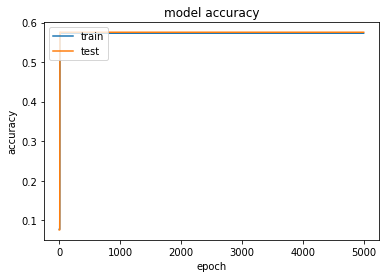

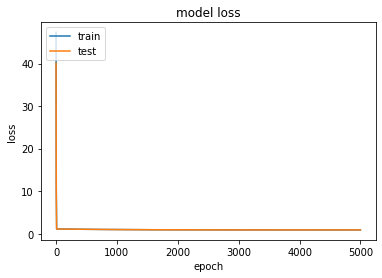

In [26]:
    model_combined_1(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

### **Result: Texture & Geometric - 2 Hidden Layer**

Epoch 00010: early stopping
Train: 34.979, Validation: 34.884, Test: 35.088


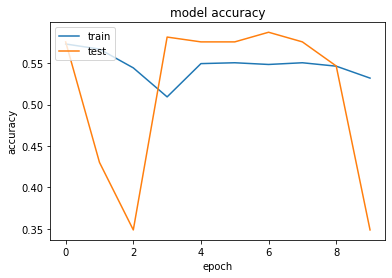

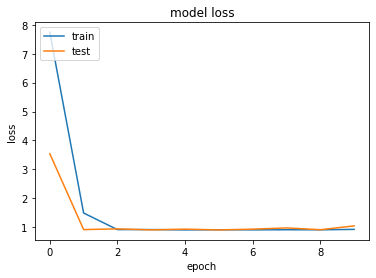

In [27]:
    model_combined_2(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

### **Result: Texture & Geometric - 3 Hidden Layer**

Epoch 00047: early stopping
Train: 57.305, Validation: 57.558, Test: 57.895


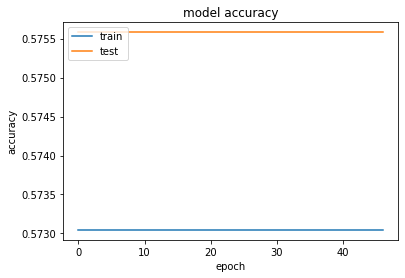

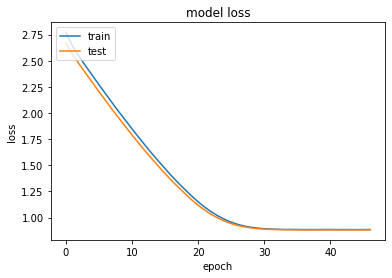

In [28]:
    model_combined_3(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

In [0]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')